In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
from emcee import EnsembleSampler
import corner

In [7]:
# global variables
# nsamples
# number of kinematical points
# number of parameters
# scaler
# pca
# gpe

In [55]:
# function to train PCA and GPE, returns trained PCA, GPE, SS

ss = StandardScaler()

def train_PCA_GPE(training_data, theta, primary_components = 2): 

    training_data_scaled = ss.fit_transform(training_data)    
    pca = PCA(n_components = primary_components, whiten = True)
    training_data_PCAd = pca.fit_transform(training_data_scaled)
    gpes = []
    
    for z in training_data_PCAd.T[:primary_components]: # optimize hyper parameters for each pc
        kernel = 1 * RBF(length_scale = 1 * np.ones(theta.shape[1]), length_scale_bounds = (1e-10, 1e10)) + 1 * WhiteKernel()
        gpe = GaussianProcessRegressor(kernel = kernel,  n_restarts_optimizer = 5) #, normalize_y = True)
        gpes.append(gpe.fit(theta, z))
    
    return gpes, pca, ss

def invert_cov(cov, var_trans, nsamples, nkp):
    return np.dot(np.array(cov).T, var_trans).reshape(nsamples, nkp, nkp) # A.T * cov * A ?

def return_predictions(emulators, theta, return_std_ = True):
    gpes = emulators[0]
    pca = emulators[1]
    ss = emulators[2]
    nsamples = len(theta)
    npc = len(gpes) # number of principal components
    nkp = np.shape(ss.scale_)[0] # number of kinematical points
                   
    mean_prediction = []
    cov_prediction = []
    
    for gpe in gpes: # predicts per principal component: len(gpes) = npc 
        
        mean, cov = gpe.predict(theta, return_cov = return_std_)
        gp_var2 = cov.diagonal()[:, np.newaxis]
        
        mean_prediction.append(mean)
        cov_prediction.append(gp_var2)

    # inverse transform mean prediction
    pred_r = ss.inverse_transform(pca.inverse_transform(np.array(mean_prediction).T))
    
    # make transformation matrix for error
    trans_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) # transformation matrix
    A = trans_matrix[:npc] 
    var_trans = np.einsum('ki,kj->kij', A, A, optimize = False).reshape(npc, nkp**2)
    
    # inverse transform diagonal covariance matrix
    cov_rpca = invert_cov(cov_prediction, var_trans, nsamples, nkp)
    std_preds = np.sqrt(np.diagonal(cov_rpca, axis1 = 1, axis2 = 2)) # standard devs are just
    err_r = ss.scale_ * std_preds 
    return pred_r, err_r

# log formulas

# log likelihood
def log_likelihood(theta, emulators, data, data_err): # one set of theta only
    theta_reshaped = theta.reshape(1,-1)
    predict, predict_err = return_predictions(emulators, theta_reshaped, return_std_ = True)    
    err2 = (predict_err**2 + (data_err)**2) 
    ll = np.log(2*np.pi*err2) + ((data - predict)**2) / err2 #np.log is natural log 
    return -.5*np.sum(ll)

# some flat prior that sets the bounds of the parameters
def log_flat_prior(theta, l_bounds, u_bounds):
    
    for i in range(np.size(theta)): # check if each parameter is within bounds
        if theta[i] < l_bounds[i] or theta[i] > u_bounds[i]:
            return -np.inf
       
    return 0

# posterior
def log_posterior(theta, l_bounds, u_bounds, emulators, data, data_err):
    return log_likelihood(theta, emulators, data, data_err) + log_flat_prior(theta, l_bounds, u_bounds)

# emcee sampler function
def emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, data, data_err):
    sampler = EnsembleSampler(n_walkers, n_params, log_posterior, args = [l_bounds, u_bounds, emulators, data, data_err], threads = 4) # default is stretchmove
    return sampler

def return_samples(p0, l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler):
    burn = sampler.run_mcmc(p0, n_burn, progress = True) # initially train until samples converge
    sampler.reset() # remove burn samples
    run = sampler.run_mcmc(burn, n_samples, progress = True)
    return sampler.get_chain(flat = True)

In [9]:
#fig_label = "4p100d232k"

folder = "mve/plainLHS/100d" #"mve/hybrid" #"mve/orthLHS/121d" # w3p20d
train_file, theta_file = [folder + "/train.dat", folder + "/theta.dat"]
exp_file = "exp_all.dat"

param_names = [r"$Q_{s0}^{2}$ (GeV²)",
               r"$e_c$",
               r"$C^{2}$",
               r"$\sigma_0/2$ (mb)"] # ordered

# cut training data ()
exp_df = pd.DataFrame(np.loadtxt(exp_file), columns = ['xbj', 'Qs2', 'sqrt(s)', 'sigma_r', 'error'])
a, b = 2.0, 50.0 
# Q2_region = exp_df['Qs2'] < 10.0 # boolean
Q2_region = (exp_df['Qs2'] >= a) & (exp_df['Qs2'] <= b)
Q2_index = exp_df.index[Q2_region].tolist()
exp_df_cut = exp_df[Q2_region]
exp = np.array(exp_df_cut['sigma_r'])
exp_err = np.array(exp_df_cut['error'])

In [10]:
train_dataset = pd.DataFrame(np.loadtxt(train_file))
train_dataset = train_dataset.iloc[:, Q2_index].T.reset_index(drop=True).T
params_all = np.vstack(np.loadtxt(theta_file, unpack = True)).T
n_params = len(param_names)
training_set_all = train_dataset.iloc[:,np.array(train_dataset.columns)].values
myparams, myparams_test, training_set, training_set_test = train_test_split(params_all, 
                                                                            training_set_all, 
                                                                            test_size = 0.10, 
                                                                            random_state = 10)

Text(0, 0.5, '$\\sigma_0/2$ (mb)')

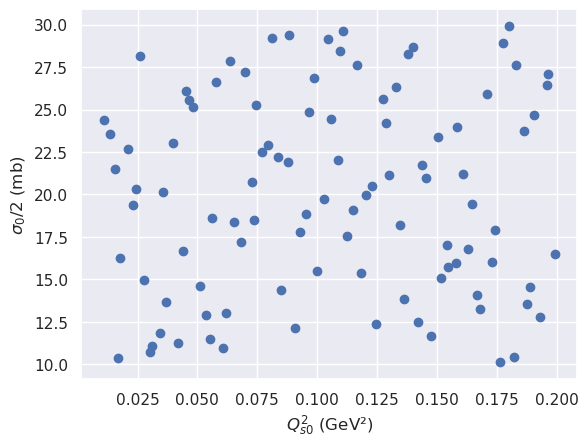

In [11]:
plt.plot(params_all[:,0], params_all[:,-1], 'o')
plt.xlabel(r"$Q_{s0}^{2}$ (GeV²)")
plt.ylabel(r"$\sigma_0/2$ (mb)")

/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/caaucasu/.conda/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/caaucasu/.

Text(0, 0.5, 'Mean z-score')

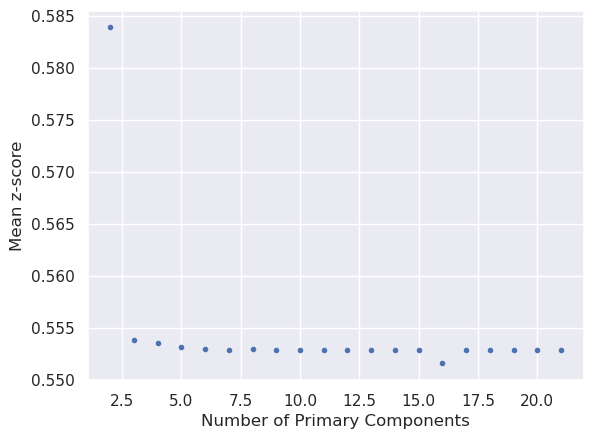

In [12]:
# space for validating() the gpe emulator
z = np.zeros(20)
ems = []
prims = []
for i in range(20):
    prim = i + 2
    prims.append(prim)
    emulators0 = train_PCA_GPE(training_set, myparams, primary_components = prim)
    ems.append(emulators0)
    pred_rs, err_rs = return_predictions(ems[i], myparams_test, return_std_ = True)
    z_mean = []
    for f in range(np.shape(pred_rs)[1]):
        zs = np.mean(np.abs(pred_rs[:,f] - training_set_test[:,f]) / err_rs[:,f])
        z_mean.append(zs)
    z[i] = np.mean(z_mean)
    #z[i] = emulators0[3]
        #z[i] = np.mean(np.abs(err_rs))

npc = np.where( z == np.amin(z, axis = 0))[0][0] + 2
fig = plt.plot(prims, z, '.')
plt.xlabel("Number of Primary Components")
plt.ylabel("Mean z-score")

In [13]:
# train pca, scaler, and gpe
npc = 6
emulators = train_PCA_GPE(training_set, myparams, primary_components = npc)
# return predictions of fits
pred_r, err_r = return_predictions(emulators, myparams_test, return_std_ = True)

0.845 0.034061361995668935
[0.03560514 0.140232   0.01665482 0.15042113 0.19923319 0.08110605
 0.13459363 0.03117425 0.15783103 0.02609078]


Text(0, 0.5, 'reduced xsec')

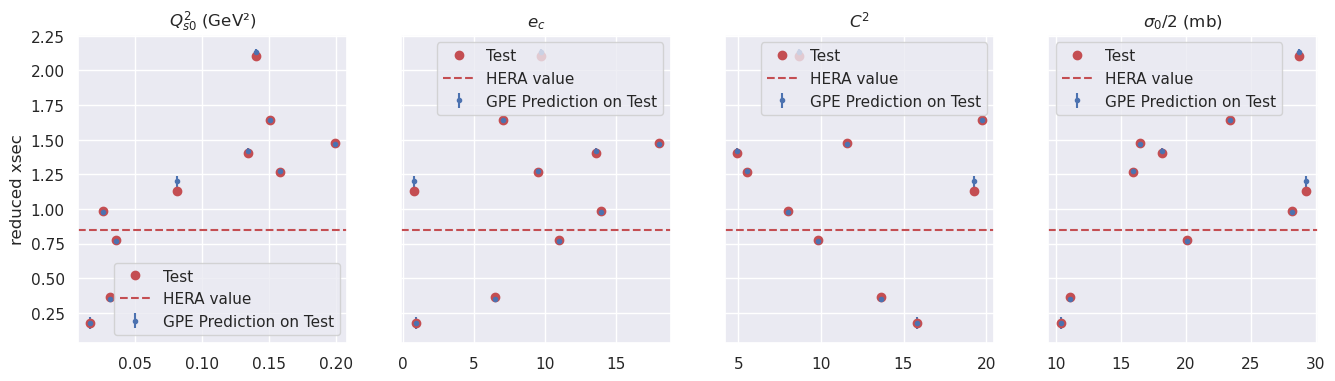

In [14]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 10
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].errorbar(myparams_test[:,i], pred_r[:,kp], fmt = '.', yerr = err_r[:,kp], label = "GPE Prediction on Test")
    ax[i].plot(myparams_test[:,i], training_set_test[:,kp], 'ro', label = 'Test')
    ax[i].axhline(exp[kp],  color = 'r', linestyle = '--', label = 'HERA value')
    ax[i].set_title(param_names[i])
    ax[i].legend()

# ax[1].set_xscale("log")    
print(exp[kp], exp_err[kp])
print(myparams_test[:,0])
ax[0].set_ylabel("reduced xsec")

Text(0.5, 0, 'Training Data $\\sigma_r$')

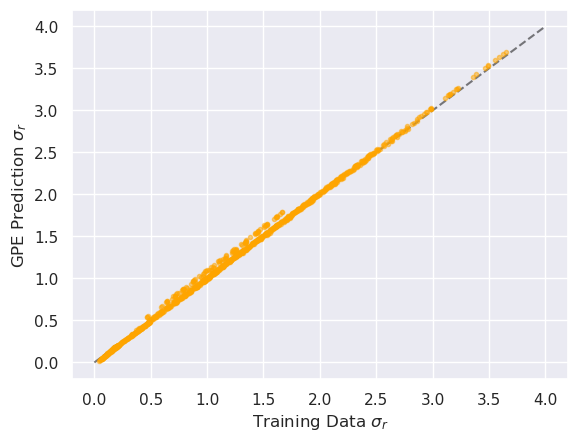

In [15]:
diag = np.linspace(0, 4)
plt.plot(diag, diag, '--', color = 'black', alpha = 0.5)

for i in range(100):
    plt.plot(training_set_test[:,i], pred_r[:,i], '.', color = "orange", alpha = 0.5)

plt.ylabel("GPE Prediction $\sigma_r$")
plt.xlabel("Training Data $\sigma_r$")

Text(0, 0.5, 'z score')

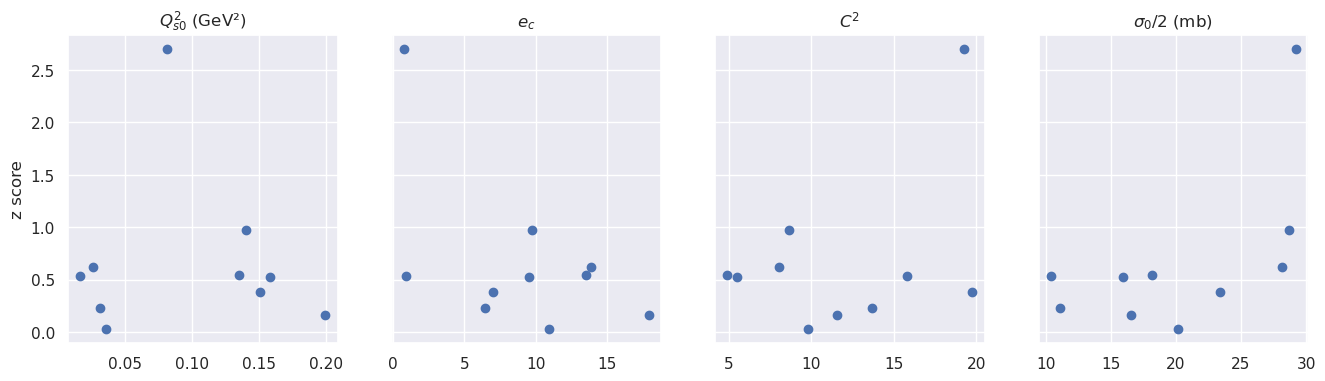

In [16]:
# plot for first kinematical point, comparing training data value and gpe prediction
kp = 50
f, ax = plt.subplots(1, n_params, sharey = True, figsize=(16,4))
for i in range(0,n_params):
    ax[i].plot(myparams_test[:,i], np.abs(pred_r[:,kp] - training_set_test[:,kp]) / err_r[:,kp], 'o')
    ax[i].set_title(param_names[i])

ax[0].set_ylabel("z score")

In [17]:
# are there still negative values in the err_r
for i in range(len(exp)):
    for num in err_r[:,i]:
        if num < 0:
            print(num, end=" ")

In [69]:
# initializes the walkers in either a small space around the initial guess
# or in a largers space. Well we'll see how it goes
#l_bounds = [0.001, 0.5, 0.1, 10.0] # Qs0² , ec , C², sigma0/2
#u_bounds = [0.2, 40.0, 40.0, 30.0] 
l_bounds = [0.001, 0.5, 0.1, 10.0] # Qs0² , ec , C², sigma0/2
u_bounds = [0.2, 40.0, 40.0, 30.0] 
l_bounds_in = [0.05, 7.0, 5.0, 14.0] #0.060 0.238 1 7.2 18.9 16.36
u_bounds_in = [0.09, 11.0, 7.0, 16.0]

mylimits = np.array([l_bounds, u_bounds])
n_walkers = 100
n_burn = 1000
n_samples = 1000

p0 = np.random.uniform(l_bounds_in, u_bounds_in, size = (n_walkers,n_params))
sampler1 = emcee_sampler(n_walkers, n_params, log_posterior, l_bounds, u_bounds, emulators, exp, exp_err)
paramsamples = return_samples(p0,l_bounds, u_bounds, n_walkers, n_params, n_samples, n_burn, sampler1)

for i in range(n_params): # print means
    print(param_names[i] + "= {0:.3f}".format(np.mean(paramsamples[:,i])))

print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler1.acceptance_fraction)))

100%|██████████| 1000/1000 [12:03<00:00,  1.38it/s]

$Q_{s0}^{2}$ (GeV²)= 0.077
$e_c$= 8.039
$C^{2}$= 5.589
$\sigma_0/2$ (mb)= 15.185
Mean acceptance fraction: 0.418


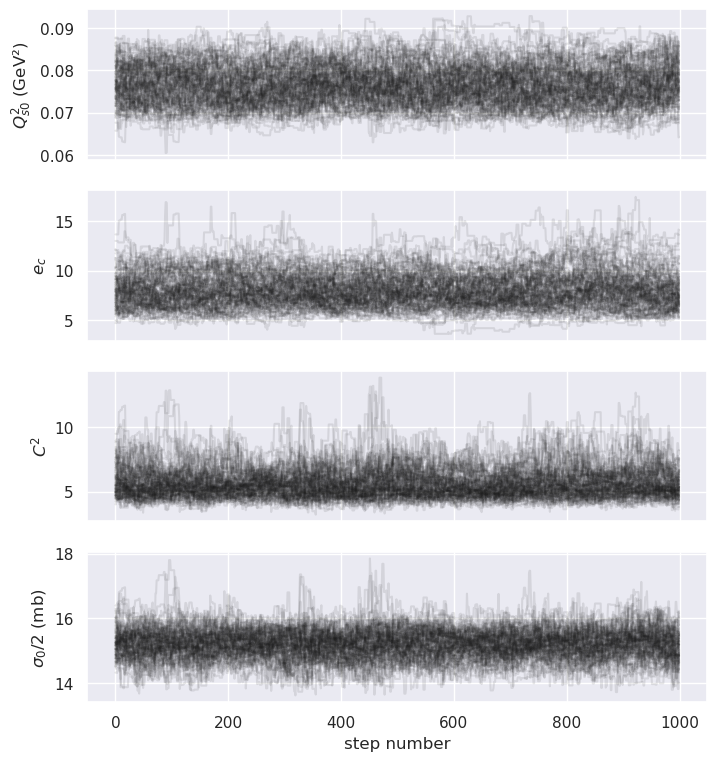

In [70]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.chain[:,:,i].T, color = 'k', alpha = 0.1)
    axes[i].set_ylabel(param_names[i])
    axes[-1].set_xlabel('step number')

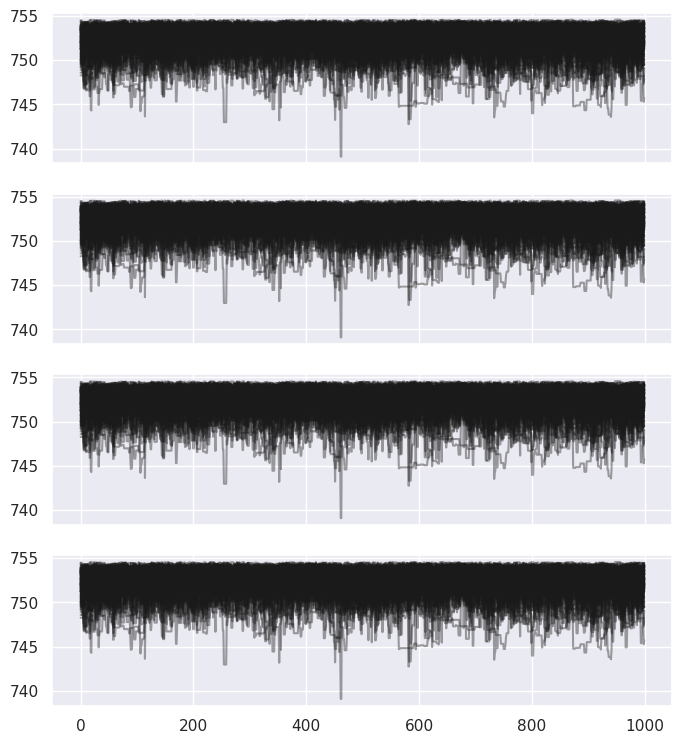

In [71]:
fig, axes = plt.subplots(n_params, 1, sharex = True, figsize = (8, 9))
for i in range(n_params):
    axes[i].plot(sampler1.get_log_prob(), color = 'k', alpha = 0.4)
    #axes[i].set_ylabel('log probability')
    #axes[-1].set_xlabel('step number')

Quantiles:
[(0.16, 0.07160923870892878), (0.5, 0.07628864704079281), (0.84, 0.08143513125020978)]
Quantiles:
[(0.16, 6.296531885390572), (0.5, 7.794012716417872), (0.84, 9.848819646439406)]
Quantiles:
[(0.16, 4.649638828602612), (0.5, 5.388816987684017), (0.84, 6.51823450871018)]
Quantiles:
[(0.16, 14.77737950020516), (0.5, 15.187877591500202), (0.84, 15.582558830671477)]


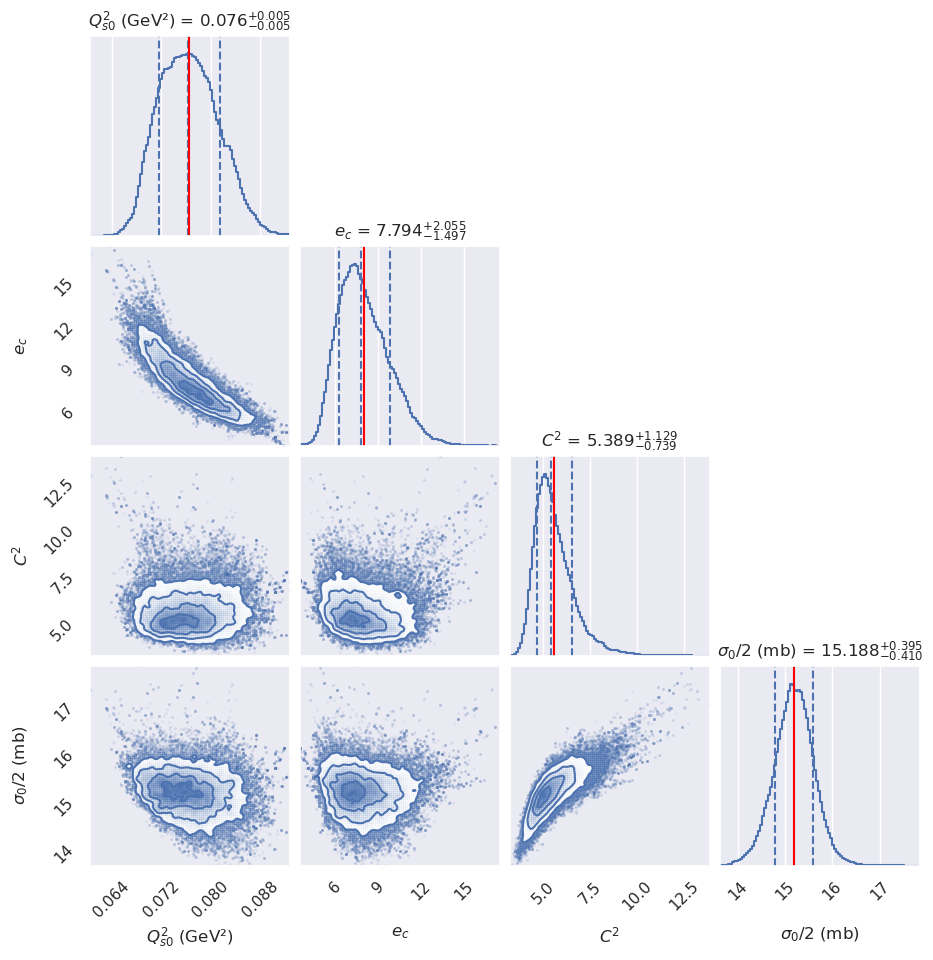

In [103]:
figure = corner.corner(
    paramsamples,
    labels = param_names,
    plot_contours = True,
    quantiles=[0.16, 0.5, 0.84],
    show_titles = True, # 
    title_fmt = '.3f',
    title_kwargs={"fontsize": 12}, 
    color = 'b',
    bins = 100,
    smooth1d = True,
    smooth = True,
    verbose = True,
    #plot_density = True,
    fillcontours = True, # 
    hist2d_kwargs = {"plot_density": True} # conto
)

ndim = n_params
axes = np.array(figure.axes).reshape((ndim, ndim))

import math
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.mean(paramsamples[:,i]), color="red")


# Loop over the histograms
#for yi in range(ndim):
#    for xi in range(yi):
#        ax = axes[yi, xi]
#        ax.axvline(np.mean(paramsamples[:,xi]), color="r")
#        ax.axhline(np.mean(paramsamples[:,yi]), color="r")
#        ax.plot(np.mean(paramsamples[:,xi]), np.mean(paramsamples[:,yi]), "sr")

In [90]:
# MAP
# peaks
# prediction for the observable is average of the prediction for each parameter set sampled from the posterior
# print(np.shape(paramsamples))

(100000, 4)


In [89]:
# how to sample from the posterior
# inds = np.random.randint(len(paramsamples), size=100)
# post_samples = [paramsamples[i] for i in inds]
# np.savetxt("mve/plainLHS/mve_100d_100w_sampled_from_posterior.txt", np.array(post_samples), delimiter = " ", newline = "\n")
# np.savetxt("mve/plainLHS/mve_100d_100w_allsamples.txt", np.array(paramsamples), delimiter = " ", newline = "\n")

In [75]:
#figure.savefig('figs/{}_{}_{}_{}.png'.format(fig_label, 'linearec', 'all', 'correcterr'))

In [83]:
posterior_params = np.vstack(np.loadtxt("mve/plainLHS/mve_100d_100w_sampled_from_posterior.txt", unpack = True)).T
model_values, model_values_err = return_predictions(emulators, posterior_params, return_std_ = True)

In [85]:
def plot_model_vs_exp(q2, ss, model_values, exp_df):
    Q2_region = (exp_df['Qs2'] == q2) & (exp_df['sqrt(s)'] == ss)
    Q2_indeces = exp_df.index[Q2_region].tolist()
    exp_df_region = exp_df[Q2_region]
    dat = np.array(exp_df_region['sigma_r'])
    dat_err = np.array(exp_df_region['error'])
    xb = np.array(exp_df_region['xbj'])
    
    splots = 2
    fig, ax = plt.subplots(1,splots, figsize = (16, 6))

    for i in range(len(model_values)):
        model = [model_values[i,qq2] for qq2 in Q2_indeces]
        ax[0].plot(xb, model, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(model_values)-1:
            ax[0].plot(xb, model, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Posterior")
        
    for i in range(len(training_set_all)):
        train = [training_set_all[i,qq2] for qq2 in Q2_indeces]
        ax[1].plot(xb, train, alpha = 0.3, color = 'orange', linewidth = 0.5)
        if i == len(pred_r)-1:
            ax[1].plot(xb, train, alpha = 0.9, color = 'orange', linewidth = 0.5, label = "Training Data")

    for i in range(splots):
        ax[i].errorbar(xb, dat, yerr = dat_err, fmt = '.', label = "HERA Data")
        ax[i].set_title("$Q^2$ = {} GeV$^{}$; ".format(q2, 2) + "$\sqrt{s}$ = " + str(ss) + " GeV")
        ax[i].set_xlabel("$x_{bj}$")
        ax[i].set_ylabel("$\sigma_r$ (mb)")
        #ax[0].set_ylim(0.5, 2.0)
        ax[i].set_xscale('log') 
        #ax[i].set_yscale('log')
        ax[i].legend()
        
    return fig
 # make cuts
 # check chi2
 

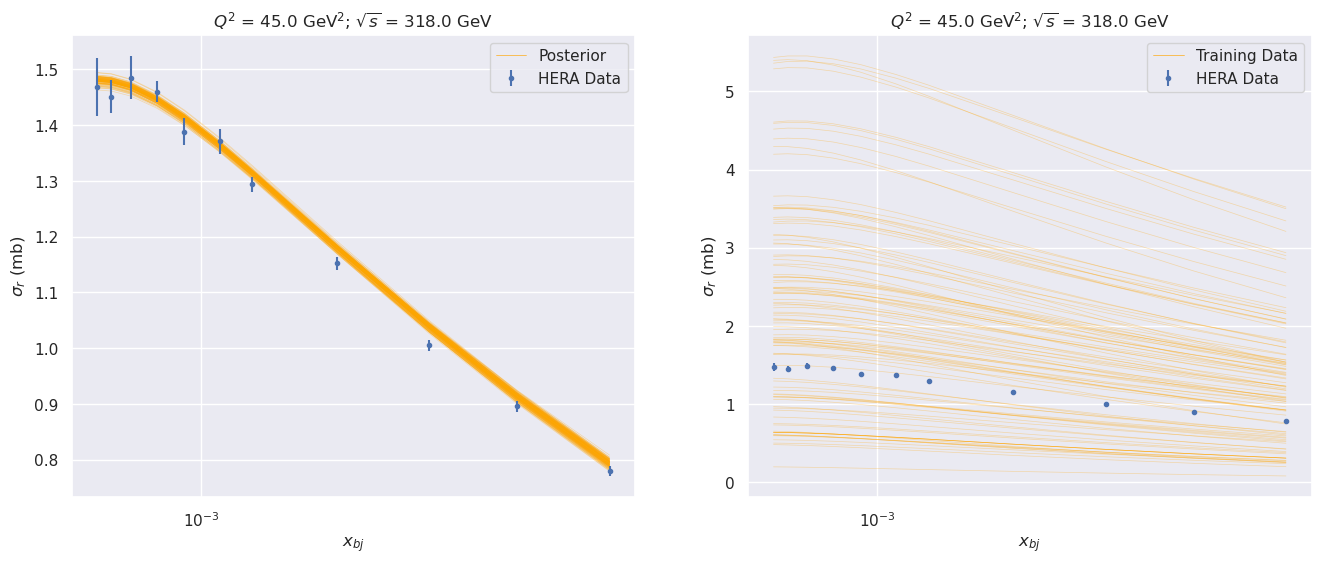

In [86]:
plot_model_vs_exp(45.0, 318.0, model_values, exp_df)
# make for each Q2?

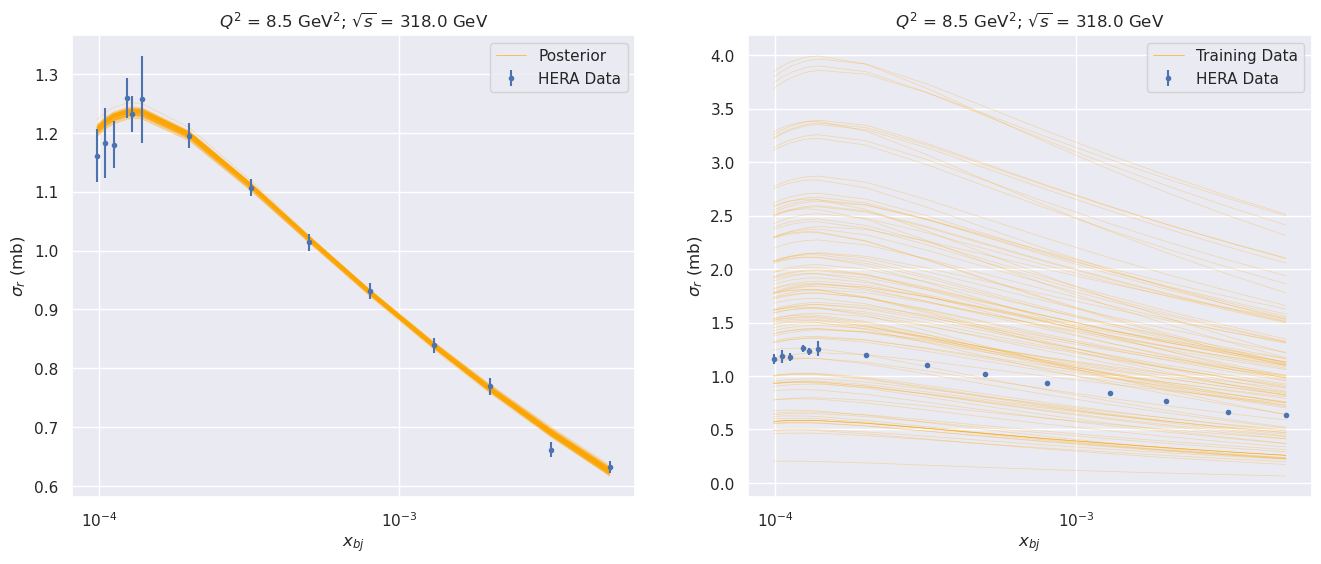

In [87]:
plot_model_vs_exp(8.5, 318.0, model_values, exp_df)

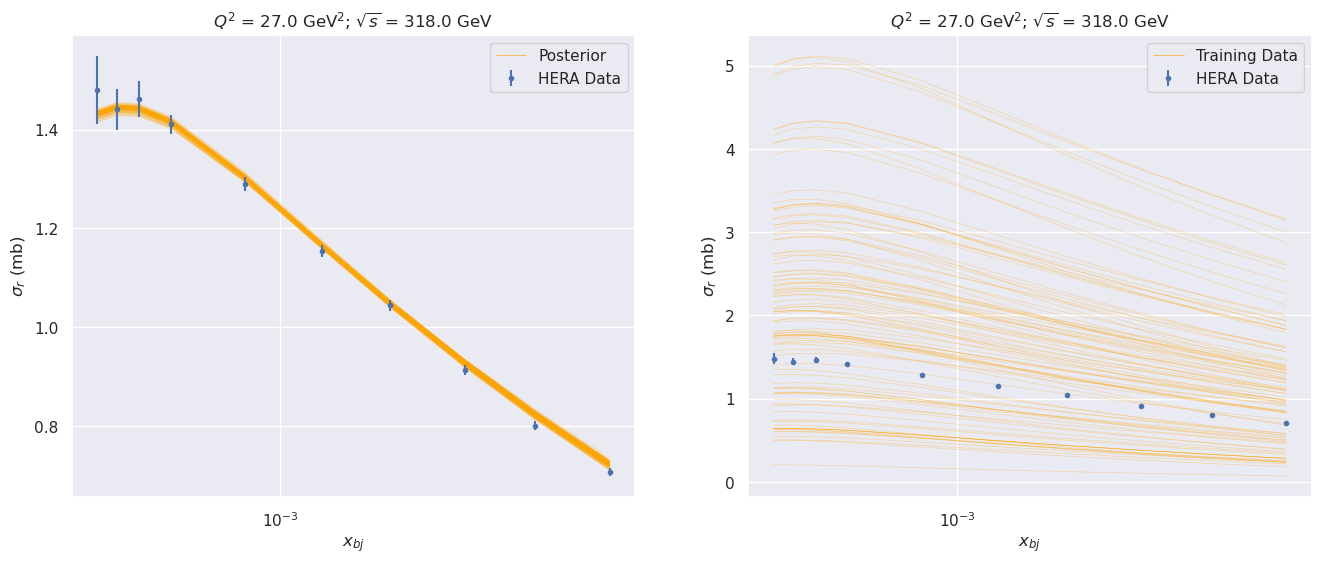

In [88]:
plot_model_vs_exp(27.0, 318.0, model_values, exp_df)